<a href="https://colab.research.google.com/github/Bkoome/GD/blob/main/Copy_of_Untitled21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

In [39]:

IMAGESIZE=256
BATCHSIZE=32
EPOCH=50
N0_CLASSES=3
RGB_CHANNEL=3
N_CLASSES=3

In [3]:
image_dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Potato/VIAZI/Training",
    shuffle=True,
    image_size=(IMAGESIZE,IMAGESIZE),
    batch_size=BATCHSIZE

)

Found 3261 files belonging to 3 classes.


In [4]:
class_name=image_dataset.class_names
class_name

['Early_Blight', 'Healthy', 'Late_Blight']

In [5]:
102*32

3264

In [6]:
len(image_dataset)

102

In [7]:
for image_batch, label_batch in image_dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[2 1 2 0 1 2 1 0 2 0 2 2 0 2 0 0 1 2 0 1 0 2 1 2 2 0 2 0 1 0 0 2]


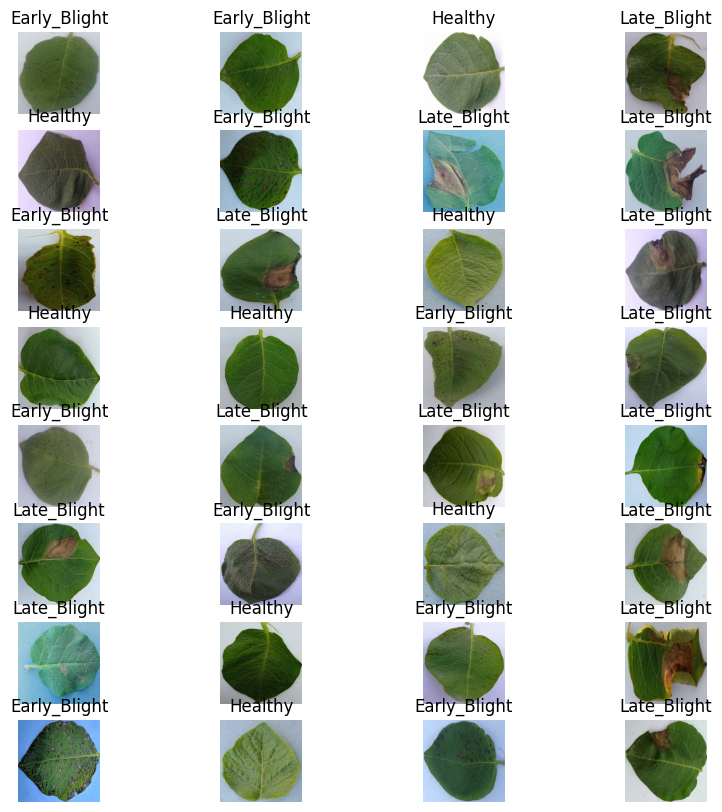

In [8]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in image_dataset.take(1):
    for i in range(32):
        ax = plt.subplot(8, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_name[label_batch[i]])
        plt.axis("off")



In [9]:
def get_dataset_partitions_tf(ds, train_split=0.8, validation_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
  assert (train_split + validation_split + test_split)==1
  ds_size=len(ds)
  if shuffle:
    ds=ds.shuffle(shuffle_size, seed=10)

  train_size=int(train_split*ds_size)
  validation_size=int(validation_split*ds_size)

  train_dataset=ds.take(train_size)
  validation_dataset=ds.take(validation_size)
  test_dataset=ds.skip(train_size).skip(validation_size)

  return train_dataset, validation_dataset, test_dataset


In [10]:
train_dataset, validation_dataset, test_dataset=get_dataset_partitions_tf(image_dataset)

In [11]:
len(train_dataset)

81

In [12]:
len(validation_dataset)


10

In [13]:
len(test_dataset)

11

In [14]:
#cache, shuffle, prefetch
train_dataset=train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset=validation_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset=test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
resize_rescale = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(IMAGESIZE, IMAGESIZE),
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

])

In [16]:

data_augumentation=tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

In [17]:
train_dataset=train_dataset.map(
    lambda x, y: (data_augumentation(x, training=True),y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [40]:

# Define the U-Net model
input_shape = (IMAGESIZE, IMAGESIZE, RGB_CHANNEL)

# Encoder
inputs = tf.keras.layers.Input(shape=input_shape)
conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

# Bottom of the U
conv4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
conv4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)

# Decoder
up5 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv4)
up5 = tf.keras.layers.Conv2D(256, 2, activation='relu', padding='same')(up5)
up5 = tf.keras.layers.concatenate([conv3, up5], axis=-1)
conv5 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(up5)
conv5 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv5)

up6 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv5)
up6 = tf.keras.layers.Conv2D(128, 2, activation='relu', padding='same')(up6)
up6 = tf.keras.layers.concatenate([conv2, up6], axis=-1)
conv6 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(up6)
conv6 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv6)

up7 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv6)
up7 = tf.keras.layers.Conv2D(64, 2, activation='relu', padding='same')(up7)
up7 = tf.keras.layers.concatenate([conv1, up7], axis=-1)
conv7 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(up7)
conv7 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv7)

# Output layer
output = tf.keras.layers.Conv2D(N_CLASSES, 1, activation='softmax')(conv7)

model = tf.keras.Model(inputs=inputs, outputs=output)


In [41]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_23 (Conv2D)          (None, 256, 256, 64)         1792      ['input_2[0][0]']             
                                                                                                  
 conv2d_24 (Conv2D)          (None, 256, 256, 64)         36928     ['conv2d_23[0][0]']           
                                                                                                  
 max_pooling2d_9 (MaxPoolin  (None, 128, 128, 64)         0         ['conv2d_24[0][0]']           
 g2D)                                                                                         

In [43]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)


In [44]:
fit_model = model.fit(
    train_dataset,
    batch_size=BATCHSIZE,
    validation_data=validation_dataset,
    verbose=1,
    epochs=EPOCH
)


Epoch 1/50


ValueError: ignored

In [22]:
accuracy=model.evaluate(test_dataset)

11/11 [==============================] - 6s 29ms/step - loss: 0.0290 - accuracy: 0.9857


Image prediction 
Original label: Early_Blight
1/1 [==============================] - 0s 266ms/step
predicted label: Early_Blight


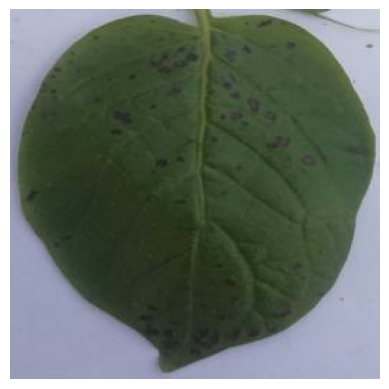

In [30]:
import numpy as np
for image_batch, label_batch in test_dataset.take(1):
    print("Image prediction ")
    plt.imshow(image_batch[0].numpy().astype('uint8'))
    print("Original label:",class_name[label_batch[0].numpy()])

    batch_prediction = model.predict(image_batch)
    print("predicted label:",class_name[np.argmax(batch_prediction[0])])
    plt.axis("off")

In [25]:
accuracy = fit_model.history['accuracy']
validation_accuracy = fit_model.history['val_accuracy']

loss = fit_model.history['loss']
validation_loss = fit_model.history['val_loss']

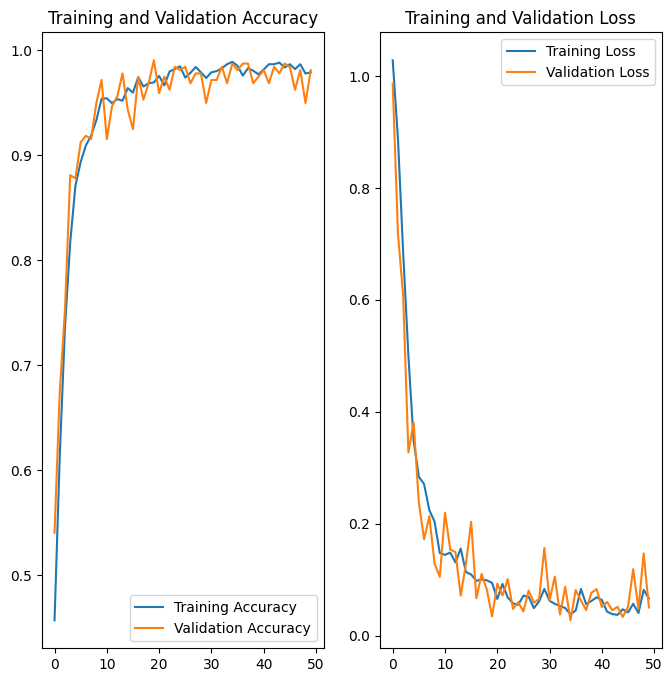

In [26]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCH), accuracy, label='Training Accuracy')
plt.plot(range(EPOCH), validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCH), loss, label='Training Loss')
plt.plot(range(EPOCH), validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [27]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [31]:
"""plt.figure(figsize=(10, 10))
for images, labels in test_dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_name[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")"""

'plt.figure(figsize=(10, 10))\nfor images, labels in test_dataset.take(1):\n    for i in range(12):\n        ax = plt.subplot(3, 4, i + 1)\n        plt.imshow(images[i].numpy().astype("uint8"))\n        \n        predicted_class, confidence = predict(model, images[i].numpy())\n        actual_class = class_name[labels[i]] \n        \n        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")\n        \n        plt.axis("off")'

In [ ]:
from tensorflow.keras.models import load_model
model.save("/content/drive/MyDrive/Potato/model_1")


In [28]:
from tensorflow.keras.models import load_model
model.save("/content/drive/MyDrive/Potato/new_model_1")


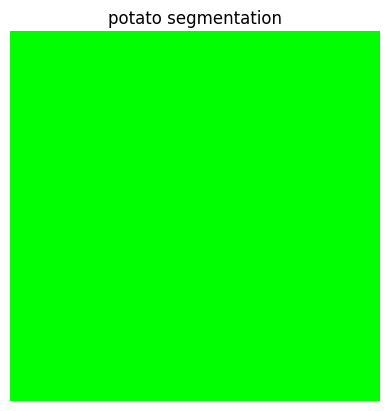

In [37]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Load your trained model
model = tf.keras.models.load_model('/content/drive/MyDrive/Potato/new_model_1')

# Load and preprocess the aerial image
image_path = '/content/drive/MyDrive/NEW_JPEG/ortho.jpg'
image = tf.keras.preprocessing.image.load_img(image_path, target_size=(IMAGESIZE, IMAGESIZE))
image_array = tf.keras.preprocessing.image.img_to_array(image)
image_array = np.expand_dims(image_array, axis=0)

# Predict the pixel-wise labels using overlapping patches
patch_size = 256  # Match the model's expected input size
stride = 128  # Adjust the stride accordingly

# Create an empty mask for segmentation
mask = np.zeros((image_array.shape[1], image_array.shape[2]))

for x in range(0, image_array.shape[1] - patch_size, stride):
    for y in range(0, image_array.shape[2] - patch_size, stride):
        patch = image_array[:, x:x+patch_size, y:y+patch_size, :]

        # Predict the label for the patch
        predictions = model.predict(patch)
        predicted_label = np.argmax(predictions, axis=-1)[0]

        mask[x:x+patch_size, y:y+patch_size] = predicted_label

# Define color mappings for each label
label_colors = {
    0: (0, 255, 0),    # Green for Healthy
    1: (255, 0, 0),    # Red for Early Blight
    2: (0, 0, 255)    # Blue for Late Blight
}

# Create a colored segmentation result
segmentation_result = np.zeros((image_array.shape[1], image_array.shape[2], 3), dtype=np.uint8)
for label, color in label_colors.items():
    segmentation_result[mask == label] = color

# Display the color-coded segmentation result
plt.figure()
plt.imshow(segmentation_result)
plt.title('potato segmentation')
plt.axis("off")
plt.show()
